### Water Segmentation using Multispectral and optical DataOur

In [2]:
# Imports
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

### Reading Data

In [3]:
def load_tiff_images(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.tif")))
    imgs, names = [], []
    for f in files:
        imgs.append(tifffile.imread(f))
        names.append(os.path.splitext(os.path.basename(f))[0])
    return np.array(imgs), names

def load_png_labels(folder):
    files = sorted(glob.glob(os.path.join(folder, "*.png")))
    labels, names = [], []
    for f in files:
        im = Image.open(f).convert("L")
        arr = np.array(im)
        labels.append((arr > 0).astype(np.uint8))
        names.append(os.path.splitext(os.path.basename(f))[0])
    return np.array(labels), names

def align_by_name(X, X_names, y, y_names):
    common = sorted(set(X_names) & set(y_names))
    if not common:
        m = min(len(X), len(y))
        return X[:m], y[:m], X_names[:m], y_names[:m]
    idx_x = [X_names.index(n) for n in common]
    idx_y = [y_names.index(n) for n in common]
    return X[idx_x], y[idx_y], common, common

X, X_names = load_tiff_images("E:/D/Cellula/Task2/week3/data/images")
y, y_names = load_png_labels("E:/D/Cellula/Task2/week3/data/labels")

X, y, _, _ = align_by_name(X, X_names, y, y_names)

### Preprocess

In [4]:
def normalize_images(X):
    X = X.astype(np.float32)
    # assume (H,W,C); normalize each image-channel independently
    for i in range(len(X)):
        for c in range(X.shape[-1]):
            ch = X[i, :, :, c]
            mn, mx = ch.min(), ch.max()
            if mx > mn:
                X[i, :, :, c] = (ch - mn) / (mx - mn)
    return X

X = normalize_images(X)
y = np.expand_dims(y, -1).astype(np.float32)

In [5]:
# Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Building model architecture

In [6]:
def create_unet(input_shape):
    inputs = keras.Input(shape=input_shape)
    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        return x
    c1 = conv_block(inputs, 64); p1 = layers.MaxPool2D()(c1)
    c2 = conv_block(p1, 128); p2 = layers.MaxPool2D()(c2)
    c3 = conv_block(p2, 256); p3 = layers.MaxPool2D()(c3)
    c4 = conv_block(p3, 512); p4 = layers.MaxPool2D()(c4)
    b  = conv_block(p4, 1024)
    def up_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, 2, strides=2, padding="same")(x)
        x = layers.concatenate([x, skip])
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        return x
    u1 = up_block(b, c4, 512)
    u2 = up_block(u1, c3, 256)
    u3 = up_block(u2, c2, 128)
    u4 = up_block(u3, c1, 64)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u4)
    return keras.Model(inputs, outputs)

### Evaluation methods

In [7]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def calc_metrics(y_true, y_prob, thresh=0.5):
    y_pred = (y_prob > thresh).astype(np.uint8).flatten()
    y_true = y_true.flatten().astype(np.uint8)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    iou = tp / (tp + fp + fn) if (tp + fp + fn) else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0.0
    return {'precision': precision, 'recall': recall, 'f1': f1, 'iou': iou, 'accuracy': accuracy,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn}

def eval_thresholds(y_true, y_prob, thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 0.95, 0.05)
    results = {}
    best_f1 = (-1, None)
    best_iou = (-1, None)
    for t in thresholds:
        m = calc_metrics(y_true, y_prob, t)
        results[round(t,2)] = m
        if m['f1'] > best_f1[0]:
            best_f1 = (m['f1'], t)
        if m['iou'] > best_iou[0]:
            best_iou = (m['iou'], t)
    results['best_f1'] = {'threshold': float(best_f1[1]), 'f1': float(best_f1[0])}
    results['best_iou'] = {'threshold': float(best_iou[1]), 'iou': float(best_iou[0])}
    return results


In [8]:
model = create_unet(input_shape=X_train.shape[1:])
model.compile(optimizer=keras.optimizers.Adam(1e-3),
                loss='binary_crossentropy',
                metrics=['accuracy', dice_coefficient])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, min_lr=1e-7)
]

In [10]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=min(8, X_train.shape[0]),
                    callbacks=callbacks
                    )

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8035 - dice_coefficient: 0.4381 - loss: 11.1834 - val_accuracy: 0.8600 - val_dice_coefficient: 0.4732 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8696 - dice_coefficient: 0.5077 - loss: 0.3687 - val_accuracy: 0.8956 - val_dice_coefficient: 0.5867 - val_loss: 0.2797 - learning_rate: 0.0010
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8921 - dice_coefficient: 0.6506 - loss: 0.2900 - val_accuracy: 0.9102 - val_dice_coefficient: 0.6377 - val_loss: 0.2466 - learning_rate: 0.0010
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8968 - dice_coefficient: 0.6617 - loss: 0.2762 - val_accuracy: 0.9109 - val_dice_coefficient: 0.6153 - val_loss: 0.2598 - learning_rate: 0.0010
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8983 - dice_coefficient: 0.6741 - loss: 0.2805 - val_accuracy: 0.9137 - val_dice_coefficient: 0.6448 - 

In [11]:
def plot_training(history):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='loss'); plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(); plt.title("Loss")
    plt.subplot(1,2,2)
    if 'dice_coefficient' in history.history:
        plt.plot(history.history['dice_coefficient'], label='dice'); plt.plot(history.history['val_dice_coefficient'], label='val_dice')
        plt.legend(); plt.title("Dice")
    plt.tight_layout(); plt.show()

def plot_threshold_results(results):
    th = sorted([k for k in results.keys() if isinstance(k, float) or isinstance(k, int)])
    f1 = [results[t]['f1'] for t in th]
    iou = [results[t]['iou'] for t in th]
    plt.plot(th, f1, '-o', label='F1'); plt.plot(th, iou, '-o', label='IoU')
    plt.xlabel('Threshold'); plt.legend(); plt.title('F1 & IoU vs Threshold'); plt.grid(True); plt.show()


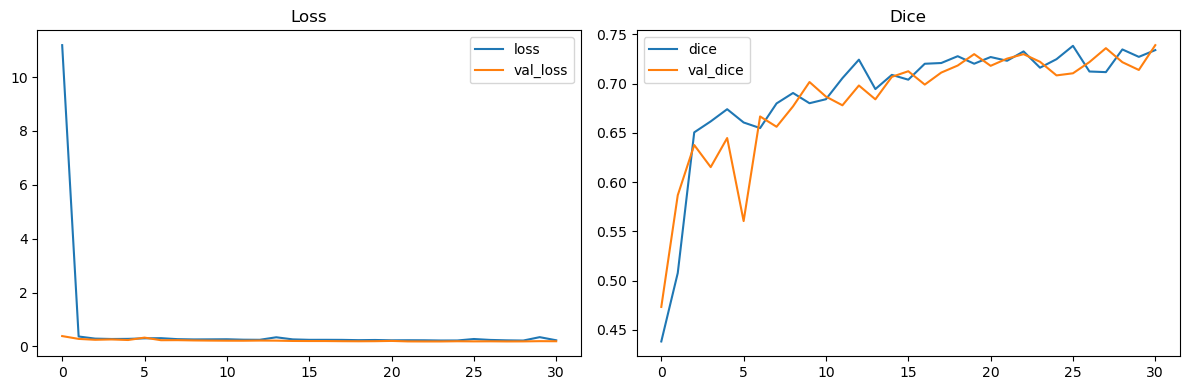

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
Best F1: {'threshold': 0.40000000000000013, 'f1': 0.8279866855318532}
Best IoU: {'threshold': 0.40000000000000013, 'iou': 0.7064652553948066}


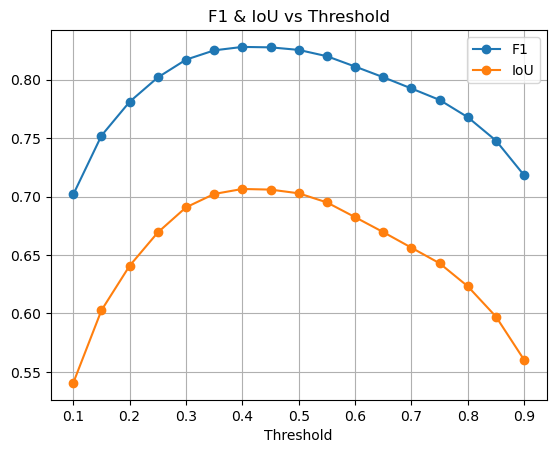

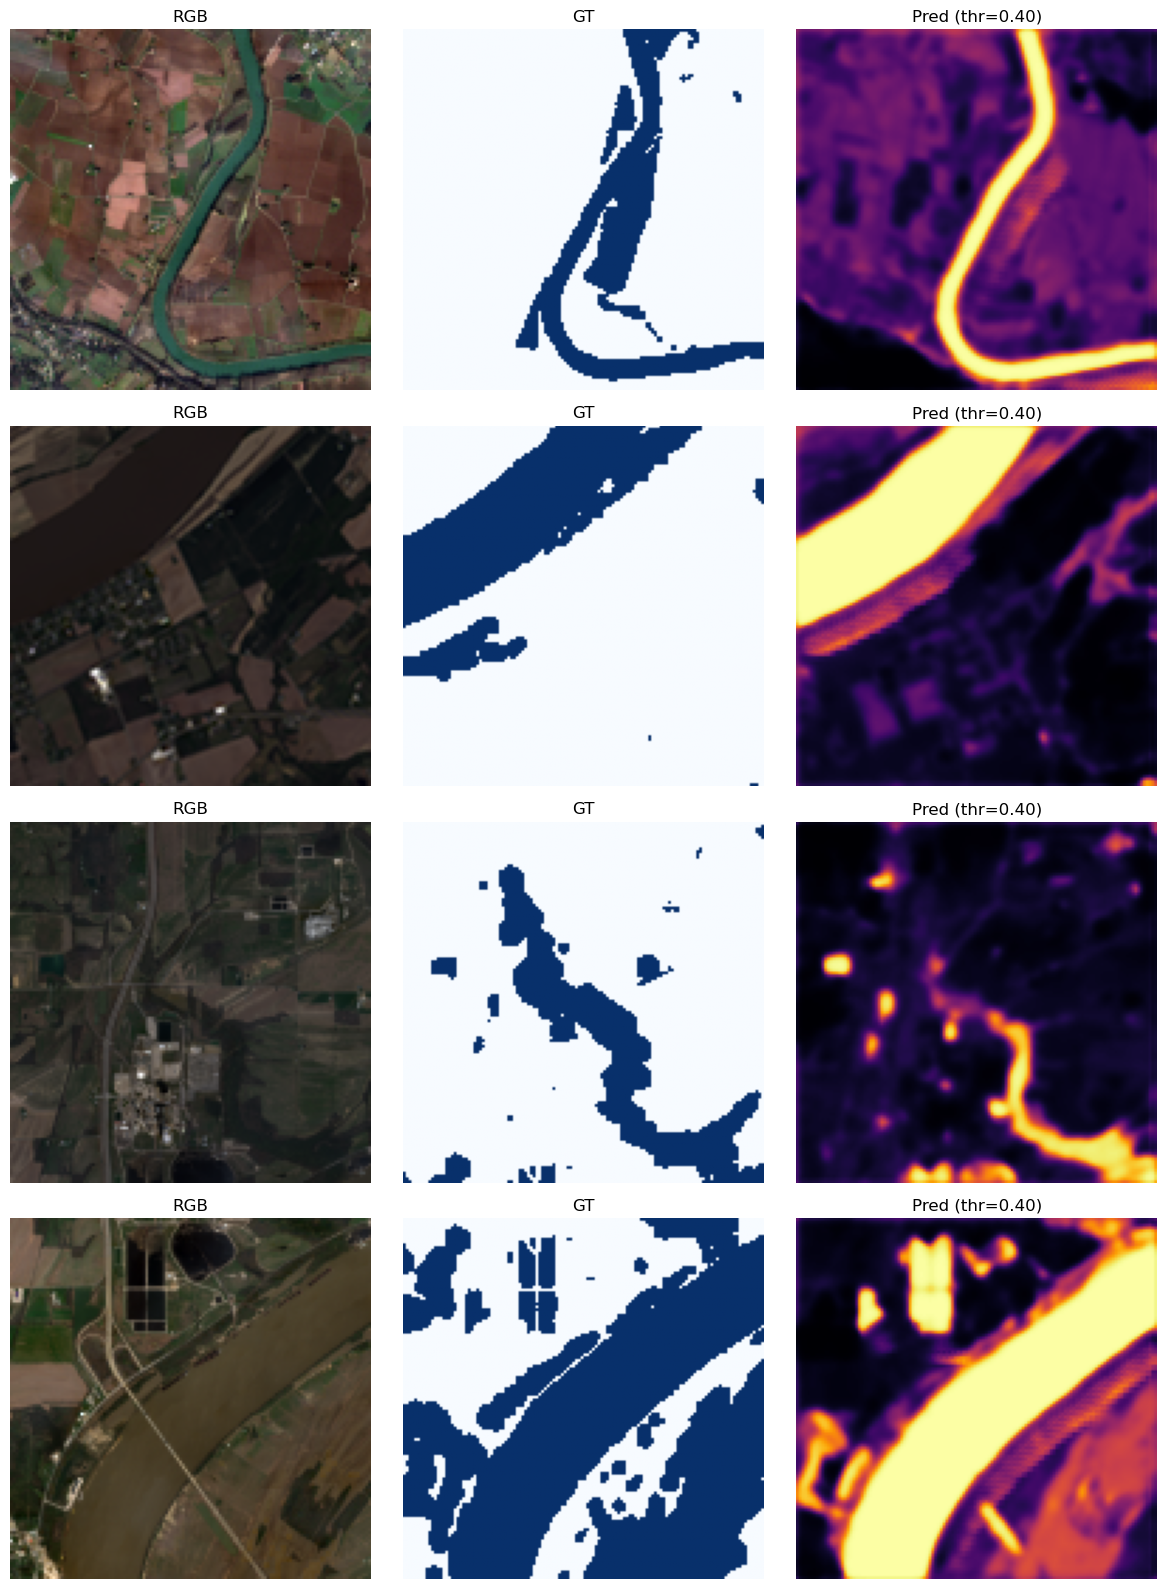

In [12]:
plot_training(history)

# Predict & evaluate
y_pred = model.predict(X_val)
thr_results = eval_thresholds(y_val, y_pred)
print("Best F1:", thr_results['best_f1'])
print("Best IoU:", thr_results['best_iou'])
plot_threshold_results(thr_results)

# Visualize a few samples (prob & bin)
n = min(4, X_val.shape[0])
best_t = thr_results['best_f1']['threshold']
fig, axs = plt.subplots(n, 3, figsize=(12, 4*n))
for i in range(n):
    rgb = np.stack([X_val[i,:,:,3], X_val[i,:,:,2], X_val[i,:,:,1]], axis=-1)
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    axs[i,0].imshow(rgb); axs[i,0].set_title("RGB"); axs[i,0].axis('off')
    axs[i,1].imshow(y_val[i].squeeze(), cmap='Blues'); axs[i,1].set_title("GT"); axs[i,1].axis('off')
    axs[i,2].imshow(y_pred[i].squeeze(), cmap='inferno', vmin=0, vmax=1); axs[i,2].set_title(f"Pred (thr={best_t:.2f})"); axs[i,2].axis('off')
plt.tight_layout(); plt.show()
